In [56]:
import pandas as pd
from pycaret.regression import setup, compare_models, tune_model, finalize_model, predict_model, plot_model

In [2]:
# Cargamos los datasets
dfpatentes = pd.read_csv('../Analisis/datasetPatentes.csv')
dfsnii = pd.read_csv('../Analisis/datasetSNII.csv')
dfwos = pd.read_csv('../Analisis/datasetWoS.csv')
dfkeys = pd.read_csv('../Analisis/Nombres_PxS.csv')

# Normalizamos nombres de columnas
for df in (dfpatentes, dfsnii, dfwos,dfkeys):
    df.columns = (
        df.columns
        .str.lower()
        .str.strip()
        .str.replace(' ', '_')
        .str.replace('-', '_')
    )

In [3]:
# Eliminamos las columnas del dfkeys 'nombre_inventor', 'nombre_del_investigador'
dfkeys = dfkeys.drop(columns=['nombre_inventor', 'nombre_del_investigador'])
# Eliminamos los NA de la columna 'inventor_id'
dfkeys = dfkeys.dropna(subset=['inventor_id'])
# Convertimos la columna 'inventor_id' a int
dfkeys['cvu'] = dfkeys['cvu'].astype(int)

In [4]:
# Contamos la cantidad nombres que hay en la columna 'authors' que estan separadas por ';'
dfwos['numCoautores'] = dfwos['authors'].str.split(';').str.len()

In [5]:
# Quitar espacios en los extremos
dfsnii['nivel'] = (
    dfsnii['nivel']
    .astype(str)              
    .str.strip()              
    .replace({
        r'.*Nivel I$': 1,
        r'.*Nivel II$': 2,
        r'.*Nivel III$': 3,
        r'.*Candidato.*': 'C',
        r'^Emérito$': 'E'
    }, regex=True)
    .astype(str)
)

# Normalizar formatos de fecha a 'YYYY-MM-DD' sin eliminar vals no estándar
def normalize_date(val):
    try:
        return pd.to_datetime(val, dayfirst=True).strftime('%Y-%m-%d')
    except Exception:
        return val

for col in ['fecha_de_inicio_de_vigencia', 'fecha_de_fin_de_vigencia']:
    dfsnii[col] = dfsnii[col].apply(normalize_date)

# Definir función para extraer años de forma segura
def safe_year(val):
    try:
        return pd.to_datetime(val, dayfirst=True, errors='coerce').year
    except:
        return None

# Extraer años de inicio y fin
dfsnii['anio_inicio'] = dfsnii['año']  # Se asume que 'año' ya está en formato correcto
dfsnii['anio_fin'] = dfsnii['fecha_de_fin_de_vigencia'].apply(safe_year)

# Ordenar por cvu y año de fin (descendente)
dfsnii = dfsnii.sort_values(['cvu', 'anio_fin'], ascending=[True, False])

# Agrupar por cvu y nivel, y calcular la actividad
def calcular_actividad(grupo):
    grupo = grupo.sort_values('anio_inicio')  # Ordenar por año de inicio
    actividad = f"{grupo['anio_inicio'].iloc[0]}-{grupo['anio_fin'].iloc[-1]}"
    return pd.Series({
        'Actividad': actividad,
        'anio_inicio': grupo['anio_inicio'].iloc[0],
        'anio_fin': grupo['anio_fin'].iloc[-1]
    })

dfsnii_actividad = (
    dfsnii.groupby(['cvu', 'nivel'])
    .apply(calcular_actividad)
    .reset_index()
)

# Quedarse con el año más reciente de cada nivel
dfsnii_recent = dfsnii_actividad.sort_values(['cvu', 'anio_fin'], ascending=[True, False])
dfsnii_recent = dfsnii_recent.drop_duplicates(subset=['cvu', 'nivel'], keep='first')

# Eliminamos la columna anio_inicio, anio_fin
dfsnii_recent = dfsnii_recent.drop(columns=['anio_inicio', 'anio_fin'])

# Limpiamos los datos
dfsnii = dfsnii.sort_values(['cvu', 'anio_inicio'], ascending=[True, False])
dfsnii = dfsnii.drop_duplicates(subset=['cvu', 'nivel'], keep='first')

# Eliminamos la columna anio_inicio, anio_fin y cruzamos con el dataset de actividad
dfsnii = dfsnii.drop(columns=['anio_inicio', 'anio_fin'])

# Convertimos int la columna cvu sin decimales del dfsnii_recent
dfsnii_recent['cvu'] = dfsnii_recent['cvu'].astype(int)
dfsnii['cvu'] = dfsnii['cvu'].astype(int)
# Quitamos el decimal a la columna 'Actividad' del dfsnii_recent
dfsnii_recent['Actividad'] = dfsnii_recent['Actividad'].str.replace('.0', '', regex=False)

# Cruzamos los dataserts para solo recuperar el Actividad dfsnii_recent
dfsnii = dfsnii.merge(dfsnii_recent, on=['cvu', 'nivel'], how='left', suffixes=('', '_y'))

# Reducir SNII a un registro por CVU (por ejemplo, el más reciente)
dfsnii = (
    dfsnii
    .sort_values("fecha_de_fin_de_vigencia")
    .drop_duplicates(subset="cvu", keep="last")
)

del dfsnii_actividad, dfsnii_recent, df

In [6]:
# Merge de las tablas
dfFinal = (
    dfkeys
      .merge(dfsnii, on="cvu", how="inner", suffixes=('', '_snii'))
      .merge(dfpatentes, on="inventor_id", how="inner", suffixes=('', '_patentes'))
      .merge(dfwos, left_on="nombre_snii", right_on="investigador", how="inner", suffixes=('', '_wos'))
)

In [52]:
dfEntrenamiento = dfFinal.copy()

# Llenamos los valores de la columna 'co_inventoras_mujeres' con 0
dfEntrenamiento['co_inventoras_mujeres'] = dfEntrenamiento['co_inventoras_mujeres'].fillna(0)
# 'número_de_coinventores'
dfEntrenamiento['número_de_coinventores'] = dfEntrenamiento['número_de_coinventores'].fillna(0)

In [53]:
# 1. Feature engineering 
# 1.1 Patentes
# Asegurarse de que las columnas sean numéricas
dfEntrenamiento['co_inventoras_mujeres'] = pd.to_numeric(dfEntrenamiento['co_inventoras_mujeres'], errors='coerce')
dfEntrenamiento['número_de_coinventores'] = pd.to_numeric(dfEntrenamiento['número_de_coinventores'], errors='coerce')

dfEntrenamiento['años_patente'] = dfEntrenamiento['última_patente'].astype(int) - dfEntrenamiento['año_de_inicio'].astype(int)

# Evitar divisiones por cero
dfEntrenamiento['prop_coinv_mujeres'] = dfEntrenamiento['co_inventoras_mujeres'] / (dfEntrenamiento['número_de_coinventores'] + 1e-9)

# 1.2 Publicaciones WoS
cols_anuales = [str(y) for y in range(2000, 2025)]
dfEntrenamiento['total_publicaciones'] = dfEntrenamiento[cols_anuales].sum(axis=1)
dfEntrenamiento['h_index'] = dfEntrenamiento['h']
dfEntrenamiento['citas_pub'] = dfEntrenamiento['total_de_citas']

# 1.3 SNII
dfEntrenamiento['vigencia_años'] = (
    pd.to_datetime(dfEntrenamiento['fecha_de_fin_de_vigencia']) -
    pd.to_datetime(dfEntrenamiento['fecha_de_inicio_de_vigencia'])
).dt.days / 365

# One-hot encoding de variables categóricas
dfEntrenamiento = pd.get_dummies(
    dfEntrenamiento,
    columns=['nivel', 'área_del_conocimiento', 'disciplina', 'entidad_federativa'],
    drop_first=True
)

# Verificar y manejar valores faltantes en columnas numéricas y categóricas
numeric_cols = ['patents', 'años_patente', 'prop_coinv_mujeres', 'h_index', 'citas_pub', 'vigencia_años']
categorical_cols = [c for c in dfEntrenamiento.columns if c.startswith(('nivel_', 'área_', 'disciplina_', 'entidad_'))]

# Validar y limpiar columnas numéricas
for col in numeric_cols:
    dfEntrenamiento[col] = pd.to_numeric(dfEntrenamiento[col], errors='coerce')
    dfEntrenamiento[col] = dfEntrenamiento[col].fillna(0)

# Validar columnas categóricas
for col in categorical_cols:
    if not pd.api.types.is_categorical_dtype(dfEntrenamiento[col]):
        dfEntrenamiento[col] = dfEntrenamiento[col].astype('category')

# Verificar que no existan valores faltantes en las columnas categóricas
dfEntrenamiento = dfEntrenamiento.dropna(subset=categorical_cols)

# Filtrar solo columnas relevantes para el modelo
columnas_modelo = numeric_cols + categorical_cols + ['total_publicaciones']
dfEntrenamiento = dfEntrenamiento[columnas_modelo].copy()

,Description,Value
0,Session id,42
1,Target,total_publicaciones
2,Target type,Regression
3,Original data shape,"(4040, 122)"
4,Transformed data shape,"(4040, 122)"
5,Transformed train set shape,"(2828, 122)"
6,Transformed test set shape,"(1212, 122)"
7,Numeric features,6
8,Categorical features,115
9,Preprocess,True


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
omp,Orthogonal Matching Pursuit,2.3817,23.4270,4.7191,0.9922,0.3052,0.1931,0.9820
lasso,Lasso Regression,2.3755,24.9786,4.8465,0.9920,0.3039,0.1715,1.4300
ridge,Ridge Regression,2.3705,23.7015,4.7555,0.9920,0.3217,0.2149,1.0360
llar,Lasso Least Angle Regression,2.3756,24.9785,4.8465,0.9920,0.3039,0.1715,0.7670
br,Bayesian Ridge,2.3715,23.7727,4.7630,0.9920,0.3217,0.2158,1.1770
huber,Huber Regressor,2.0760,25.2764,4.8856,0.9919,0.2527,0.1539,1.5390
et,Extra Trees Regressor,2.3665,34.6487,5.5133,0.9897,0.2627,0.1715,2.4370
gbr,Gradient Boosting Regressor,2.3067,36.2981,5.7093,0.9896,0.2461,0.1640,1.1770
rf,Random Forest Regressor,2.3945,40.2850,5.9993,0.9888,0.2483,0.1664,3.7090
par,Passive Aggressive Regressor,4.0817,44.4541,6.5585,0.9852,0.6078,0.5044,0.9030


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,2.7925,33.3531,5.7752,0.9943,0.2974,0.1887
1,2.5462,20.4210,4.5190,0.9868,0.3114,0.1951
2,2.3365,18.3581,4.2846,0.9844,0.3215,0.2332
3,2.2387,15.7619,3.9701,0.9966,0.2903,0.1863
4,2.8022,56.5696,7.5213,0.9888,0.2766,0.1911
5,2.2115,19.2780,4.3907,0.9944,0.3124,0.1629
6,2.1825,15.6035,3.9501,0.9928,0.3260,0.1898
7,2.1885,13.7187,3.7039,0.9971,0.2967,0.1876
8,2.3598,18.0673,4.2506,0.9958,0.3003,0.1815


Fitting 10 folds for each of 10 candidates, totalling 100 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Orthogonal Matching Pursuit,2.2943,25.8691,5.0862,0.9918,0.2995,0.2030


Columnas disponibles en preds: ['patents', 'años_patente', 'prop_coinv_mujeres', 'h_index', 'citas_pub', 'vigencia_años', 'nivel_2', 'nivel_3', 'nivel_C', 'nivel_E', 'área_del_conocimiento_II.- BIOLOGÍA Y QUÍMICA', 'área_del_conocimiento_III.- MEDICINA Y CIENCIAS DE LA SALUD', 'área_del_conocimiento_IV.- HUMANIDADES Y CIENCIAS DE LA CONDUCTA', 'área_del_conocimiento_V.- CIENCIAS SOCIALES', 'área_del_conocimiento_V.- HUMANIDADES.', 'área_del_conocimiento_VI.- BIOTECNOLOGÍA Y CIENCIAS AGROPECUARIAS', 'área_del_conocimiento_VI.- CIENCIAS SOCIALES', 'área_del_conocimiento_VII.- CIENCIAS DE AGRICULTURA, AGROPECUARIAS, FORESTALES Y DE ECOSISTEMAS', 'área_del_conocimiento_VII.- INGENIERÍAS', 'área_del_conocimiento_VII.- INGENIERÍAS ', 'área_del_conocimiento_VIII.- INGENIERÍAS Y DESARROLLO TECNOLÓGICO', 'disciplina_AGRONOMIA', 'disciplina_BIOLOGIA CELULAR', 'disciplina_BIOLOGIA MOLECULAR', 'disciplina_BIOQUIMICA', 'disciplina_CALCULO DE PROBABILIDADES', 'disciplina_CAMBIO Y DESARROLLO SOCIAL',

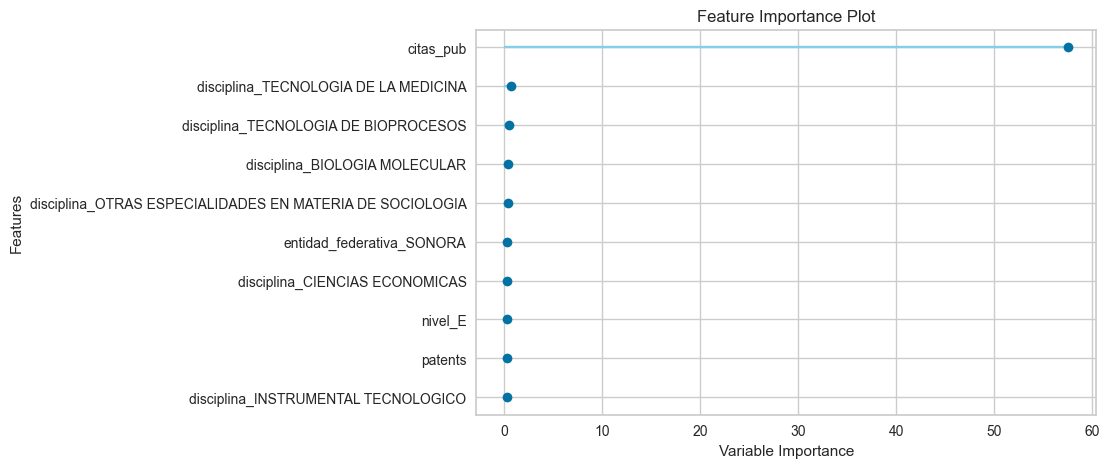

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Orthogonal Matching Pursuit,2.3401,24.2606,4.9255,0.9928,0.2979,0.1838


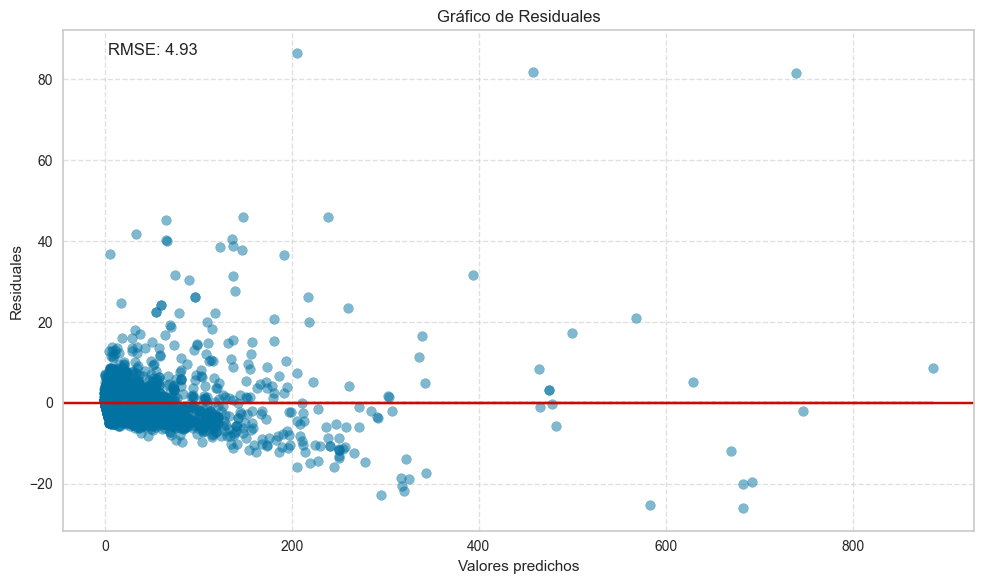

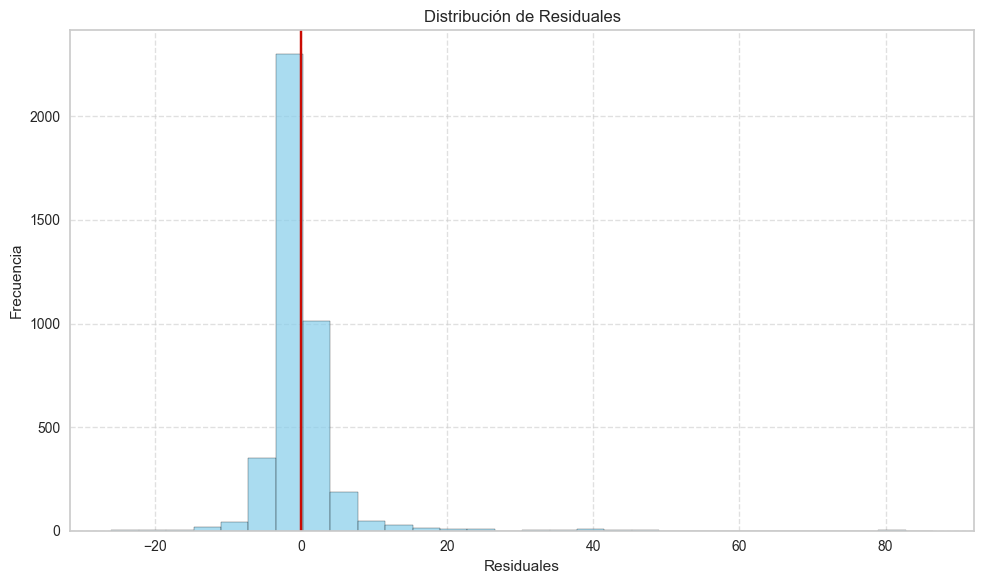

In [65]:
# 2. Definir experimento en PyCaret
exp = setup(
    data=dfEntrenamiento,
    target='total_publicaciones',  # Variable objetivo: publicaciones
    numeric_features=numeric_cols,
    categorical_features=categorical_cols,
    normalize=True,
    imputation_type=None,  # Desactivar imputación automática
    session_id=42
)

# 3. Comparar y tunear modelos
best = compare_models()           # Elegir el mejor modelo
tuned = tune_model(best)          # Afinar el modelo
final = finalize_model(tuned)     # Entrenar en todo el conjunto de datos

# 4. Predicción sobre hold-out (por ejemplo, últimos 20%)
# Asegurarnos que el holdout tiene las mismas columnas que el dataset de entrenamiento
df_holdout = dfEntrenamiento.sample(frac=0.2, random_state=42)
preds = predict_model(final, data=df_holdout)

# Mostrar las columnas disponibles en preds
def print_pred_cols(df):
    print("Columnas disponibles en preds:", list(df.columns))
    cols = [c for c in ['total_publicaciones', 'Label', 'Score'] if c in df.columns]
    print(df[cols].head())

print_pred_cols(preds)

# 5. Resultados (plots sobre el conjunto completo)
# Solo generamos el gráfico de importancia de variables que funciona correctamente
plot_model(final, plot='feature')  # Importancia de variables

# En lugar de usar plot_model, vamos a crear manualmente un gráfico de residuales
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_squared_error

# Predecir sobre el conjunto completo de datos
preds_full = predict_model(final, data=dfEntrenamiento)

# Calcular residuales
# Verificar si la columna 'Label' existe, de lo contrario usar 'prediction_label'
predicted_column = 'Label' if 'Label' in preds_full.columns else 'prediction_label'
residuals = dfEntrenamiento['total_publicaciones'] - preds_full[predicted_column]

# Crear gráfico de residuales vs valores predichos
plt.figure(figsize=(10, 6))
plt.scatter(preds_full[predicted_column], residuals, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='-')
plt.xlabel('Valores predichos')
plt.ylabel('Residuales')
plt.title('Gráfico de Residuales')
z = np.polyfit(preds_full[predicted_column], residuals, 1)
p = np.poly1d(z)
plt.plot(preds_full[predicted_column], p(preds_full[predicted_column]), 'r--', alpha=0.5)

# Mostrar RMSE
rmse = mean_squared_error(dfEntrenamiento['total_publicaciones'], preds_full[predicted_column], squared=False)
plt.annotate(f'RMSE: {rmse:.2f}', xy=(0.05, 0.95), xycoords='axes fraction', fontsize=12)

plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

# Histograma de residuales
plt.figure(figsize=(10, 6))
plt.hist(residuals, bins=30, alpha=0.7, color='skyblue', edgecolor='black')
plt.axvline(x=0, color='r', linestyle='-')
plt.xlabel('Residuales')
plt.ylabel('Frecuencia')
plt.title('Distribución de Residuales')
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()